In [1]:

import os
import pickle
import numpy as np
from PIL import Image
import trimesh
import open3d
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from pose_estimation.icp import icp
from pose_estimation import PoseData, PoseDataNPZ, PoseDataNPZTorch, COLOR_PALETTE
from pose_estimation.utils import back_project, show_points, compare_points, compute_rre, compute_rte, crop_and_resize

WORKDIR = f"{os.getcwd()}/.."
DATA_FOLDER = os.path.join(WORKDIR, "data_folder")

MODELS_PATH = os.path.join(DATA_FOLDER, "models")
TRAIN_PATH = os.path.join(DATA_FOLDER, "training_data")
TEST_PATH = os.path.join(DATA_FOLDER, "testing_data")

TRAIN_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz")
TEST_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz_test")


In [2]:
source_banana = trimesh.load(f"{DATA_FOLDER}/banana.source.ply").vertices
target_banana = trimesh.load(f"{DATA_FOLDER}/banana.target.ply").vertices
gt_banana = np.loadtxt(f"{DATA_FOLDER}/banana.pose.txt")

RUN_ICP_SANITY = False
if RUN_ICP_SANITY:
    iterations = 20
    attempts = 10
    # Visualization
    T = icp(source_banana, target_banana, attempts=10)
    rre = np.rad2deg(compute_rre(T[:3, :3], gt_banana[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_banana[:3, 3])
    print(f"rre={rre}, rte={rte}")
    compare_points(source_banana @ T[:3, :3].T + T[:3, 3], target_banana)


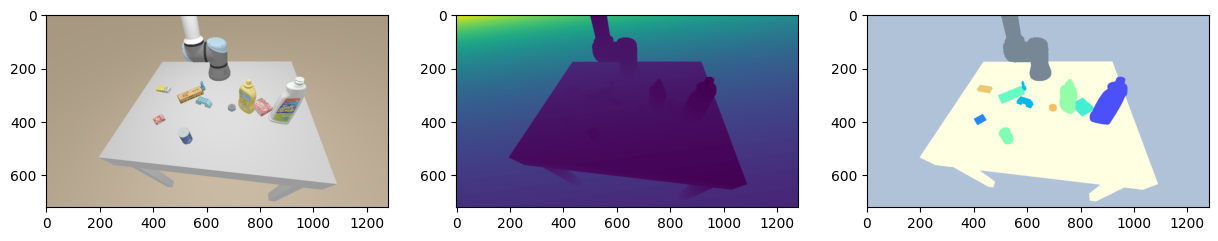

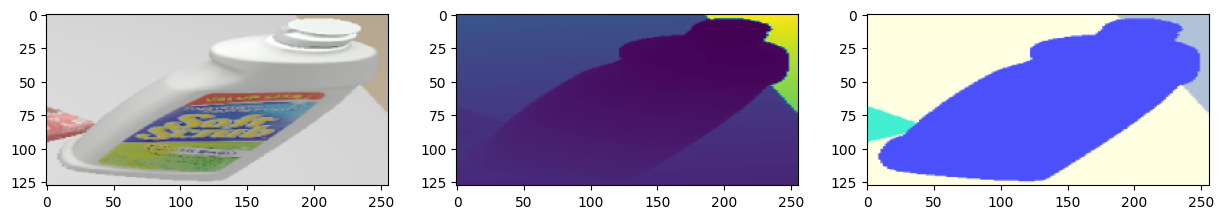

In [16]:

data = PoseData(TRAIN_PATH, MODELS_PATH)

scene = data[2, 1, 1]
rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

mask = label == np.unique(label)[0]
target_size = (256, 128)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

rgb_cr, _ = crop_and_resize(rgb, mask, target_size=target_size)
depth_cr, _ = crop_and_resize(depth, mask, target_size=target_size)
label_cr, scale = crop_and_resize(COLOR_PALETTE[label], mask, target_size=target_size)

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb_cr)
plt.subplot(1, 3, 2)
plt.imshow(depth_cr)
plt.subplot(1, 3, 3)
plt.imshow(label_cr)  # draw colorful segmentation


2341
['bowl', 'bowl_a', 'cracker_box', 'gelatin_box', 'jenga', 'pan_tefal', 'plate', 'pudding_box', 'rubiks_cube', 'sugar_box']
[[ 9.88317150e-01 -1.52411035e-01 -2.94202868e-04 -2.27053341e-02]
 [ 1.52410922e-01  9.88317141e-01 -3.74046782e-04 -2.09650514e-01]
 [ 3.47774594e-04  3.24837120e-04  9.99999887e-01  1.53505783e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-9.8828959e-01  1.5259042e-01  3.5307443e-05 -2.3226280e-02]
 [-1.5259042e-01 -9.8828959e-01 -7.7917226e-05 -2.0993699e-01]
 [ 2.3004555e-05 -8.2392362e-05  1.0000000e+00  1.5001869e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

rre=180.0, rte=0.0006892402218599145


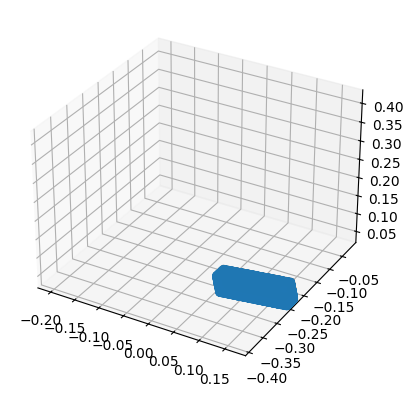

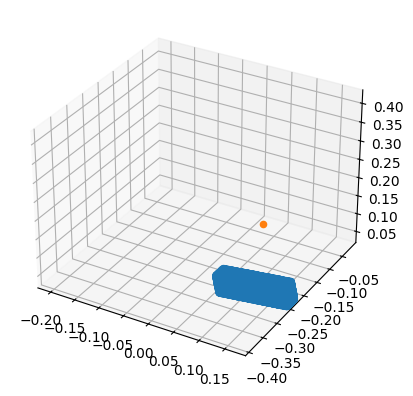

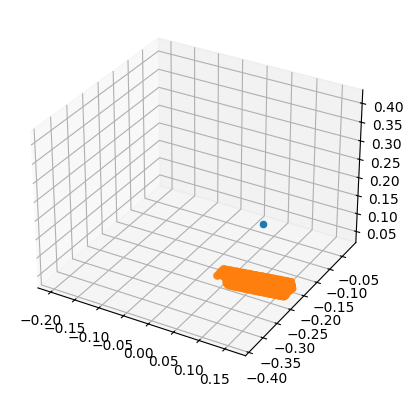

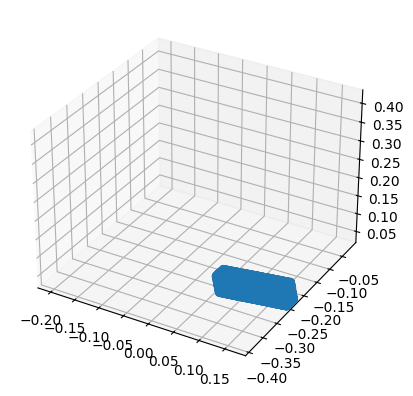

In [4]:
TEST_ICP = True
if TEST_ICP:

    selection = 3, 2, 2
    scene = data[selection]

    rgb = scene["color"]() * 255
    depth = scene["depth"]() / 1000
    label = scene["label"]()
    meta = scene["meta"]

    back_projection = back_project(depth, meta, world=True)

    item = 4
    obj_id = meta["object_ids"][item]

    indices = np.where(label == obj_id)
    obj_pnts = back_projection[indices]
    obj_rgb = rgb[indices]

    NUM_POINTS = len(obj_pnts)
    print(NUM_POINTS)
    SAMPLES = 20_000 # NUM_POINTS # 20_000

    mesh = data.get_mesh(obj_id)
    source_pcd, faces = trimesh.sample.sample_surface(mesh, SAMPLES)

    source_pcd = source_pcd * meta["scales"][obj_id]
    target_pcd = obj_pnts # / meta["scales"][obj_id] # Back Projected

    print(meta["object_names"])

    scale = 0.1
    translate = np.mean(obj_pnts, axis=0)

    attempts = 10
    # Visualization
    T = icp(source_pcd, target_pcd, attempts=attempts)

    print(T)
    gt_T = meta["poses_world"][obj_id]
    print(gt_T)
    print("")

    rre = np.rad2deg(compute_rre(T[:3, :3], gt_T[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_T[:3, 3])
    print(f"rre={rre}, rte={rte}")

    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], target_pcd, scale=scale, translate=translate)

    # These are individual plots and will also point at the origin (stray points)
    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], np.zeros((1, 3)), scale=scale, translate=translate)
    compare_points(np.zeros((1, 3)), target_pcd, scale=scale, translate=translate)

    compare_points(source_pcd @ gt_T[:3, :3].T + gt_T[:3, 3], target_pcd,  scale=scale, translate=translate)


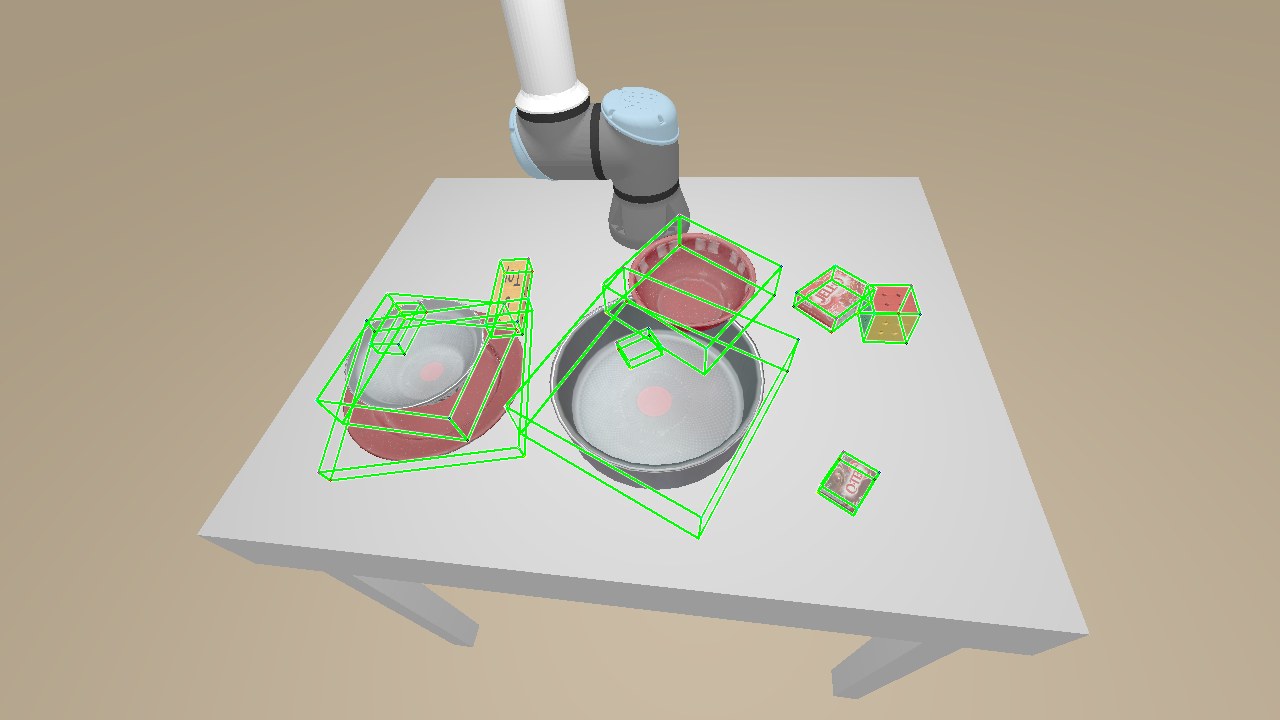

In [5]:
from pose_estimation import draw_projected_box3d

poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))


In [6]:
ICP_RUN = True
if ICP_RUN:
    data = PoseData(TEST_PATH, MODELS_PATH)

    MESH_SAMPLES = None
    ICP_ATTEMPTS = 10

    results = {}
    print(len(data))
    for i, key in enumerate(data.keys()):

        print(i, key)

        l, s, v = key

        scene = data[key]

        rgb = scene["color"]() * 255
        depth = scene["depth"]() / 1000
        label = scene["label"]()
        meta = scene["meta"]
        
        back_projection = back_project(depth, meta)

        world_frames = [None] * 79

        object_ids = [object_id for object_id in np.unique(label) if object_id < 79]

        for object_id in object_ids:

            indices = np.where(label == object_id)
            obj_pnts = back_projection[indices]
            obj_rgb = rgb[indices]

            mesh = data.get_mesh(object_id)
            source_pcd, faces = trimesh.sample.sample_surface(mesh, len(obj_pnts) if MESH_SAMPLES in [-1, 0, None, False] else MESH_SAMPLES)

            source_pcd = source_pcd * meta["scales"][object_id]
            target_pcd = obj_pnts

            T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

            world_frames[object_id] = T.tolist()

            results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


200
0 (1, 19, 1)


KeyboardInterrupt: 

In [ ]:
data_npz = PoseDataNPZ(TRAIN_NPZ_PATH)

print(len(data_npz))


Presumed Preloaded NPZ Dataset: /Users/armanommid/Code/CSE/CSE275/HW2/XSwinDiffusion/../dataset_npz
NPZ Path Already Exists: /Users/armanommid/Code/CSE/CSE275/HW2/XSwinDiffusion/../dataset_npz
5769


In [ ]:
dataset = PoseDataset(TRAIN_PATH, MODELS_PATH, mesh_samples=20_000)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

print(len(dataset))

for i, (s, t, p, e) in enumerate(data_loader):

    index = e[0].int().item()
    key = tuple(torch.tensor(e[2]).tolist())

    rgb = dataset.rgbs[key]
    depth = dataset.depths[key]
    label = dataset.labels[key]

    print(key)
    print(np.unique(label))

    print(t.shape)

    indices = dataset.indices[index]

    crop = crop_image_using_segmentation(rgb, indices)

    # plt.figure(figsize=(15, 10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(rgb)
    # plt.figure(figsize=(15, 10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(crop)
    # plt.figure(figsize=(15, 10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(rgb[indices])

    # assert 0

        
    


NameError: name 'PoseDataset' is not defined

In [ ]:



T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

world_frames[object_id] = T.tolist()

results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


NameError: name 'source_pcd' is not defined

In [ ]:
import json
with open("results.json", "w") as f:
    json.dump(results, f)
